In [59]:
import xarray as xr
import pandas as pd
import progressbar
import numpy as np
from oggm.utils import mkdir
import matplotlib.pyplot as plt

In [2]:
%pwd

'/home/www/fmaussion/runs/runs_diff_calib_protect'

In [3]:
dirpath = 'output/ERA5/elev_bands/qc3/pcp1.6/'

In [4]:
import os
allfiles = []
for root, dirs, files in os.walk(dirpath):
    for file in files:
        if file.endswith(".nc"):
             allfiles.append(os.path.join(root, file))

In [5]:
allfiles = sorted(allfiles)
allfiles[:10]

['output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp126.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp245.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp370.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/BCC-CSM2-MR/BCC-CSM2-MR_ssp585.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp119.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp126.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp245.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp370.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/CAMS-CSM1-0/CAMS-CSM1-0_ssp585.nc',
 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI01/CESM2-WACCM/CESM2-WACCM_ssp126.nc']

In [6]:
rgi_meta = pd.read_hdf('/home/www/oggm/rgi/rgi62_stats.h5')

In [9]:
df_meta = pd.DataFrame()
invalid_per_reg = {}  
meta_per_reg = {}

for f in progressbar.progressbar(allfiles):
    ename = f.replace('output/ERA5/elev_bands/qc3/pcp1.6/', '')
    ss = ename.split('/')
    exp = ss[0]
    rgi_reg = ss[1]
    gcm = ss[2]
    ssp = ename.split('.')[0].split('_')[-1]
    
    if ssp not in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        continue
    
    run_id = f'{exp}:{gcm}:{ssp}:{rgi_reg}'
    df_meta.loc[run_id, 'exp'] = exp
    df_meta.loc[run_id, 'gcm'] = gcm
    df_meta.loc[run_id, 'ssp'] = ssp
    df_meta.loc[run_id, 'rgi_reg'] = rgi_reg
    df_meta.loc[run_id, 'end_year'] = 0
    df_meta.loc[run_id, 'perc_area_missing'] = 0
    df_meta.loc[run_id, 'fpath'] = f
    
    if rgi_reg not in invalid_per_reg:
        invalid_per_reg[rgi_reg] = set()
    
    if rgi_reg not in meta_per_reg:
        meta_per_reg[rgi_reg] = rgi_meta.loc[rgi_meta['O1Region'] == rgi_reg[-2:]]
    
    with xr.open_dataset(f) as ds:
        df_meta.loc[run_id, 'end_year'] = int(ds.time[-1])
        missing_ids = ds.rgi_id[ds.isel(time=-1).volume.isnull()].data
        perc = meta_per_reg[rgi_reg].loc[missing_ids]['Area'].sum() / meta_per_reg[rgi_reg]['Area'].sum() 
        df_meta.loc[run_id, 'perc_area_missing'] = perc
        invalid_per_reg[rgi_reg] = invalid_per_reg[rgi_reg].union(missing_ids)

100% (3567 of 3567) |####################| Elapsed Time: 0:01:37 Time:  0:01:37


In [10]:
dds = df_meta.sort_values('perc_area_missing', ascending=False)
dds.loc[dds.perc_area_missing > 0.05]

exp            gcm  \
match_geod_pergla:MRI-ESM2-0:ssp126:RGI06   match_geod_pergla     MRI-ESM2-0   
no_match:MRI-ESM2-0:ssp126:RGI06                     no_match     MRI-ESM2-0   
match_geod:MRI-ESM2-0:ssp126:RGI06                 match_geod     MRI-ESM2-0   
match_geod_pergla:MRI-ESM2-0:ssp126:RGI12   match_geod_pergla     MRI-ESM2-0   
match_geod_pergla:BCC-CSM2-MR:ssp370:RGI12  match_geod_pergla    BCC-CSM2-MR   
...                                                       ...            ...   
match_geod:GFDL-ESM4:ssp245:RGI12                  match_geod      GFDL-ESM4   
match_geod:MRI-ESM2-0:ssp126:RGI12                 match_geod     MRI-ESM2-0   
match_geod:MPI-ESM1-2-HR:ssp245:RGI12              match_geod  MPI-ESM1-2-HR   
match_geod:MPI-ESM1-2-HR:ssp585:RGI12              match_geod  MPI-ESM1-2-HR   
match_geod:MPI-ESM1-2-HR:ssp370:RGI12              match_geod  MPI-ESM1-2-HR   

                                               ssp rgi_reg  end_year  \
match_geod_pergla:MRI-ESM2-0:ssp126:RGI06   ssp126   RGI06    2301.0   
no_match:MRI-ESM2-0:ssp126:RGI06            ssp126   RGI06    2301.0   
match_geod:MRI-ESM2-0:ssp126:RGI06          ssp126   RGI06    2301.0   
match_geod_pergla:MRI-ESM2-0:ssp126:RGI12   ssp126   RGI12    2301.0   
match_geod_pergla:BCC-CSM2-MR:ssp370:RGI12  ssp370   RGI12    2101.0   
...                                            ...     ...       ...   
match_geod:GFDL-ESM4:ssp245:RGI12           ssp245   RGI12    2101.0   
match_geod:MRI-ESM2-0:ssp126:RGI12          ssp126   RGI12    2301.0   
match_geod:MPI-ESM1-2-HR:ssp245:RGI12       ssp245   RGI12    2101.0   
match_geod:MPI-ESM1-2-HR:ssp585:RGI12       ssp585   RGI12    2101.0   
match_geod:MPI-ESM1-2-HR:ssp370:RGI12       ssp370   RGI12    2101.0   

                                            perc_area_missing  \
match_geod_pergla:MRI-ESM2-0:ssp126:RGI06            0.186253   
no_match:MRI-ESM2-0:ssp126:RGI06                     0.149601   
match_geod:MRI-ESM2-0:ssp126:RGI06                   0.149545   
match_geod_pergla:MRI-ESM2-0:ssp126:RGI12            0.119227   
match_geod_pergla:BCC-CSM2-MR:ssp370:RGI12           0.119216   
...                                                       ...   
match_geod:GFDL-ESM4:ssp245:RGI12                    0.119216   
match_geod:MRI-ESM2-0:ssp126:RGI12                   0.119216   
match_geod:MPI-ESM1-2-HR:ssp245:RGI12                0.119216   
match_geod:MPI-ESM1-2-HR:ssp585:RGI12                0.119216   
match_geod:MPI-ESM1-2-HR:ssp370:RGI12                0.119216   

                                                                                        fpath  
match_geod_pergla:MRI-ESM2-0:ssp126:RGI06   output/ERA5/elev_bands/qc3/pcp1.6/match_geod_p...  
no_match:MRI-ESM2-0:ssp126:RGI06            output/ERA5/elev_bands/qc3/pcp1.6/no_match/RGI...  
match_geod:MRI-ESM2-0:ssp126:RGI06          output/ERA5/elev_bands/qc3/pcp1.6/match_geod/R...  
match_geod_pergla:MRI-ESM2-0:ssp126:RGI12   output/ERA5/elev_bands/qc3/pcp1.6/match_geod_p...  
match_geod_pergla:BCC-CSM2-MR:ssp370:RGI12  output/ERA5/elev_bands/qc3/pcp1.6/match_geod_p...  
...                                                                                       ...  
match_geod:GFDL-ESM4:ssp245:RGI12           output/ERA5/elev_bands/qc3/pcp1.6/match_geod/R...  
match_geod:MRI-ESM2-0:ssp126:RGI12          output/ERA5/elev_bands/qc3/pcp1.6/match_geod/R...  
match_geod:MPI-ESM1-2-HR:ssp245:RGI12       output/ERA5/elev_bands/qc3/pcp1.6/match_geod/R...  
match_geod:MPI-ESM1-2-HR:ssp585:RGI12       output/ERA5/elev_bands/qc3/pcp1.6/match_geod/R...  
match_geod:MPI-ESM1-2-HR:ssp370:RGI12       output/ERA5/elev_bands/qc3/pcp1.6/match_geod/R...  

[168 rows x 7 columns]

In [11]:
base_dir = 'output/agg'
mkdir(base_dir)

'output/agg'

In [12]:
for exp in df_meta.exp.unique():
    odir = base_dir + f'/{exp}/'
    mkdir(odir)
    print(exp, flush=True)
    for rgi_reg in progressbar.progressbar(sorted(df_meta.rgi_reg.unique())):
        odir = base_dir + f'/{exp}/{rgi_reg}/'
        mkdir(odir)
        for ssp in sorted(df_meta.ssp.unique()):
            df_meta_s = df_meta.loc[(df_meta.exp == exp) & (df_meta.rgi_reg == rgi_reg) & (df_meta.ssp == ssp)]
            odf = pd.DataFrame()
            for i, s in df_meta_s.iterrows():
                with xr.open_dataset(s.fpath) as ds:
                    volume = ds.volume.load().isel(rgi_id=~ds.rgi_id.isin(list(invalid_per_reg[s.rgi_reg])))
                    odf[s.gcm] = volume.sum(dim='rgi_id').to_series()
            odf.to_csv(odir + f'/{ssp}.csv')

  0% (0 of 19) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

match_geod


100% (19 of 19) |########################| Elapsed Time: 0:01:27 Time:  0:01:27
  0% (0 of 19) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

match_geod_pergla


100% (19 of 19) |########################| Elapsed Time: 0:01:31 Time:  0:01:31
  0% (0 of 19) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

no_match


100% (19 of 19) |########################| Elapsed Time: 0:01:31 Time:  0:01:31


In [53]:
for exp in df_meta.exp.unique():
    print(exp, flush=True)
    odir = base_dir + f'/{exp}/global/'
    mkdir(odir)
    for ssp in sorted(df_meta.ssp.unique()):
        odf = 0
        for rgi_reg in sorted(df_meta.rgi_reg.unique()):
            idir = base_dir + f'/{exp}/{rgi_reg}/'
            df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0)
            odf += df
            # print(idir + f'/{ssp}.csv')
            # print(df['MRI-ESM2-0'].iloc[0], odf['MRI-ESM2-0'].iloc[0])
            # print(' ')
        odf.dropna(axis=0, how='all').to_csv(odir + f'/{ssp}.csv')

match_geod
match_geod_pergla
no_match


In [65]:
c

'royablue'

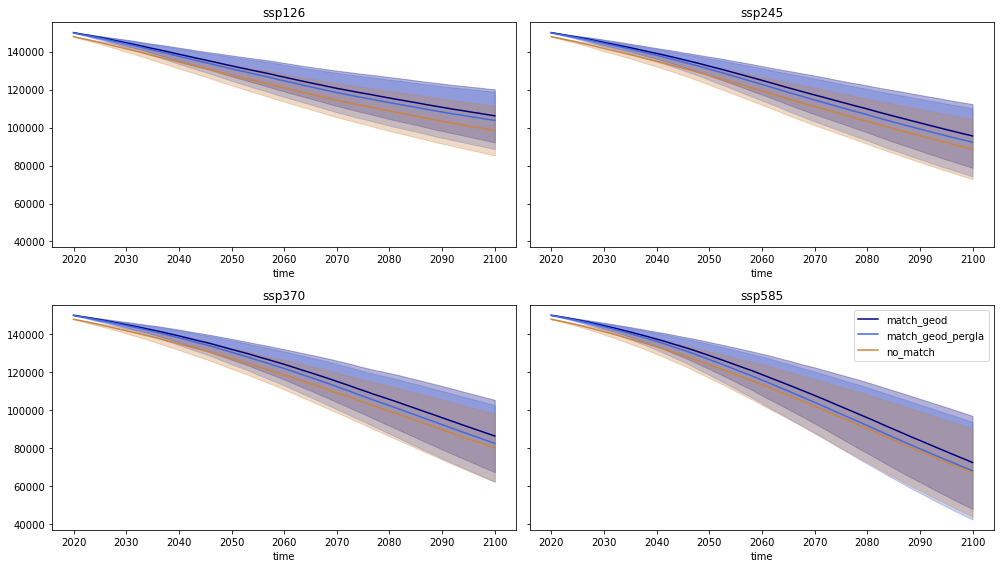

In [75]:
f, axs = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axs = np.array(axs).flatten()
for ssp, ax in zip(sorted(df_meta.ssp.unique()), axs):
    for exp, c in zip(df_meta.exp.unique(), ['navy', 'royalblue', 'peru']):
        idir = base_dir + f'/{exp}/global/'
        df = pd.read_csv(idir + f'/{ssp}.csv', index_col=0).loc[:2100]
        avg = df.mean(axis=1) * 1e-9
        std = df.std(axis=1) * 1e-9
        ax.fill_between(avg.index, avg-std, avg+std, alpha=0.3, color=c)
        avg.plot(ax=ax, label=exp, c=c);
    ax.set_title(ssp)
ax.legend();
plt.tight_layout();

In [68]:
c

'royablue'

In [ ]:
ds.isel(rgi_id=~ds.rgi_id.isin(invalid_per_reg[s.rgi_reg]))

In [ ]:
invalid_per_reg

In [ ]:
invalid_per_reg

In [ ]:
all_df_valid_rgi[rgi_reg].all

In [ ]:
ename.replace('.nc', '').replace('RGI19/', '')

In [ ]:
ename

In [ ]:
dirpath = 'output/ERA5/elev_bands/qc3/pcp1.6/match_geod/RGI06/'

In [ ]:
ds = xr.open_dataset(dirpath + 'BCC-CSM2-MR/BCC-CSM2-MR_ssp126.nc')

In [ ]:
ds.sum(dim='rgi_id').volume.plot();